# Prédiction de séries temporelles

# Consommation électrique

<img src="https://cdn.pixabay.com/photo/2019/06/25/04/40/light-4297386_1280.jpg" width=80%>

Dans cet exercice, il est demandé d'explorer les données de séries chronologiques.

> Dans cet exercice, nous utiliserons les modèles vus en cours!

Nous travaillerons avec des séries temporelle de [Open Power System Data (OPSD)](https://open-power-system-data.org/) pour l'Allemagne.

L'ensemble de données comprend la consommation d'électricité, la production d'énergie éolienne et la production d'énergie solaire entre 2015 et 2020.

- **`Date`** :  La date (format aaaa-mm-jj)
- **`Consumption`** :  Consommation électrique en GWh
- **`Wind`** : Production d'énergie éolienne en GWh
- **`Solar`** : Production d'énergie solaire en GWh
- **`Wind+Solar`** : Somme de la production d'énergie éolienne et solaire en GWh

# PARTIE 1 : Exploration des données

Chargement des données du fichier dans le dossier **data** dans une DataFrame Pandas.

Sans oublier de changer le format de la date en **`datetime`**.

In [2]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [3]:
df = pd.read_csv("data/opsd_germany_data.csv", index_col=0, parse_dates=True)
df.head()

,Consumption,Solar,Wind,Wind+Solar
Date,,,,
2014-12-31 00:00:00+00:00,0.0,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,1088317.0,17098.0,312868.0,329966.0
2015-01-02 00:00:00+00:00,1246588.0,7757.0,593022.0,600779.0
2015-01-03 00:00:00+00:00,1117554.0,7237.0,450829.0,458066.0
2015-01-04 00:00:00+00:00,1081980.0,19982.0,373525.0,393507.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2101 entries, 2014-12-31 00:00:00+00:00 to 2020-09-30 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  2101 non-null   float64
 1   Solar        2101 non-null   float64
 2   Wind         2101 non-null   float64
 3   Wind+Solar   2101 non-null   float64
dtypes: float64(4)
memory usage: 82.1 KB


In [5]:
# Controle pour s'assurer que la date a bien ete parise au chargement
df.index = pd.to_datetime(df.index)
df.index.dtype

datetime64[ns, UTC]

In [6]:
# Suppression de la valeur manquante
df = df[df.Consumption>0]

In [7]:
df.isna().sum()

Consumption    0
Solar          0
Wind           0
Wind+Solar     0
dtype: int64

### 1. Tracer et comprendre une série temporelle

Q1 - Tracage des différentes séries temporelle. 

> Ce que on comprend et ce que on remarque: 

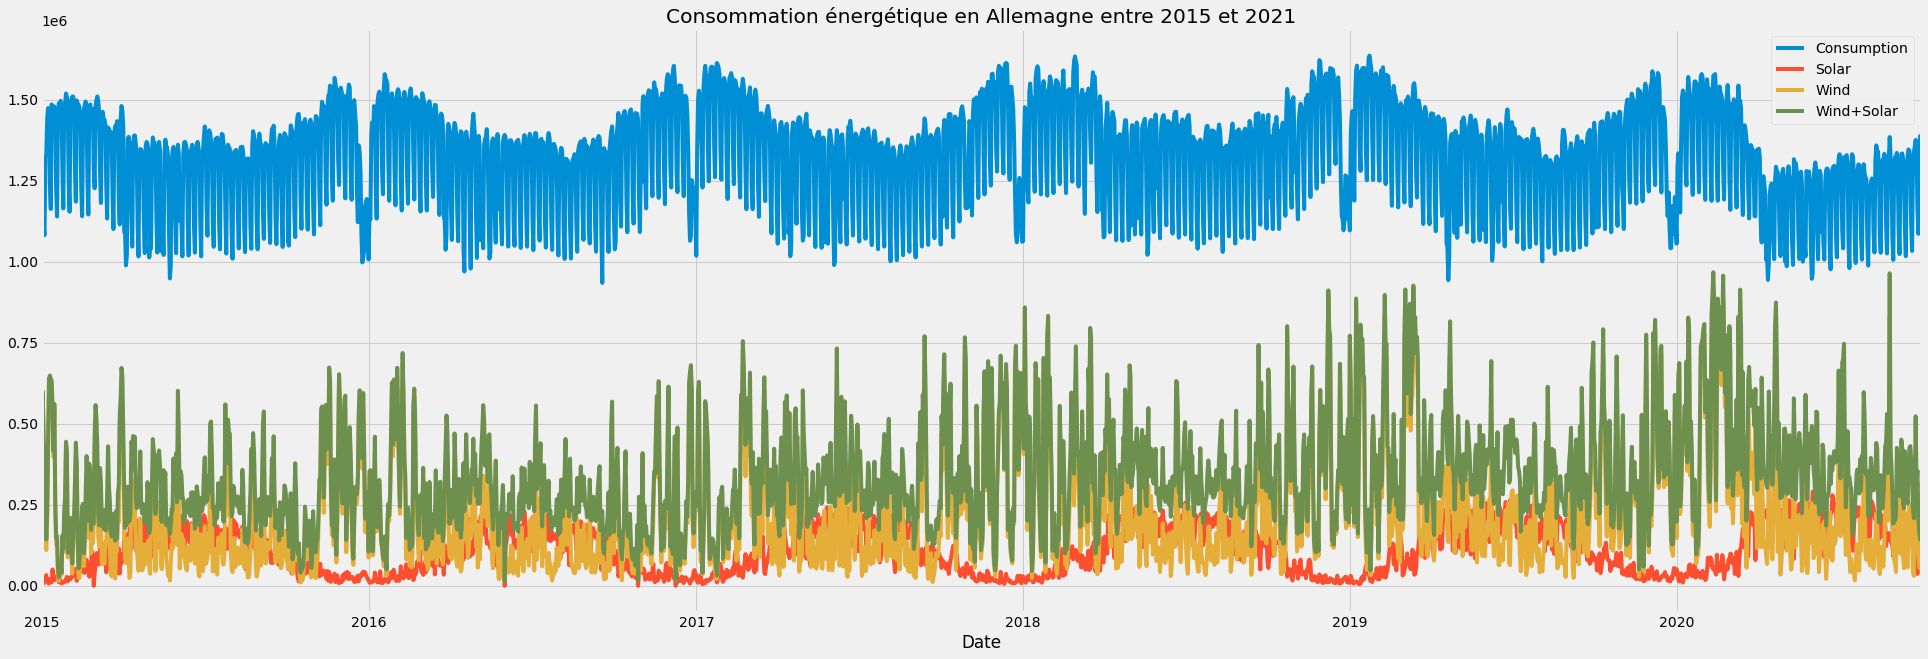

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,10))
df['Consumption'].plot()
df['Solar'].plot()
df['Wind'].plot()
df['Wind+Solar'].plot()
plt.title("Consommation énergétique en Allemagne entre 2015 et 2021")
plt.legend()
plt.show()

On peut voir une saisonnalité annuelle dans les données, wind et solar sont inversées, la consommation est plus forte en hiver, ce qui est parfaitement logique !

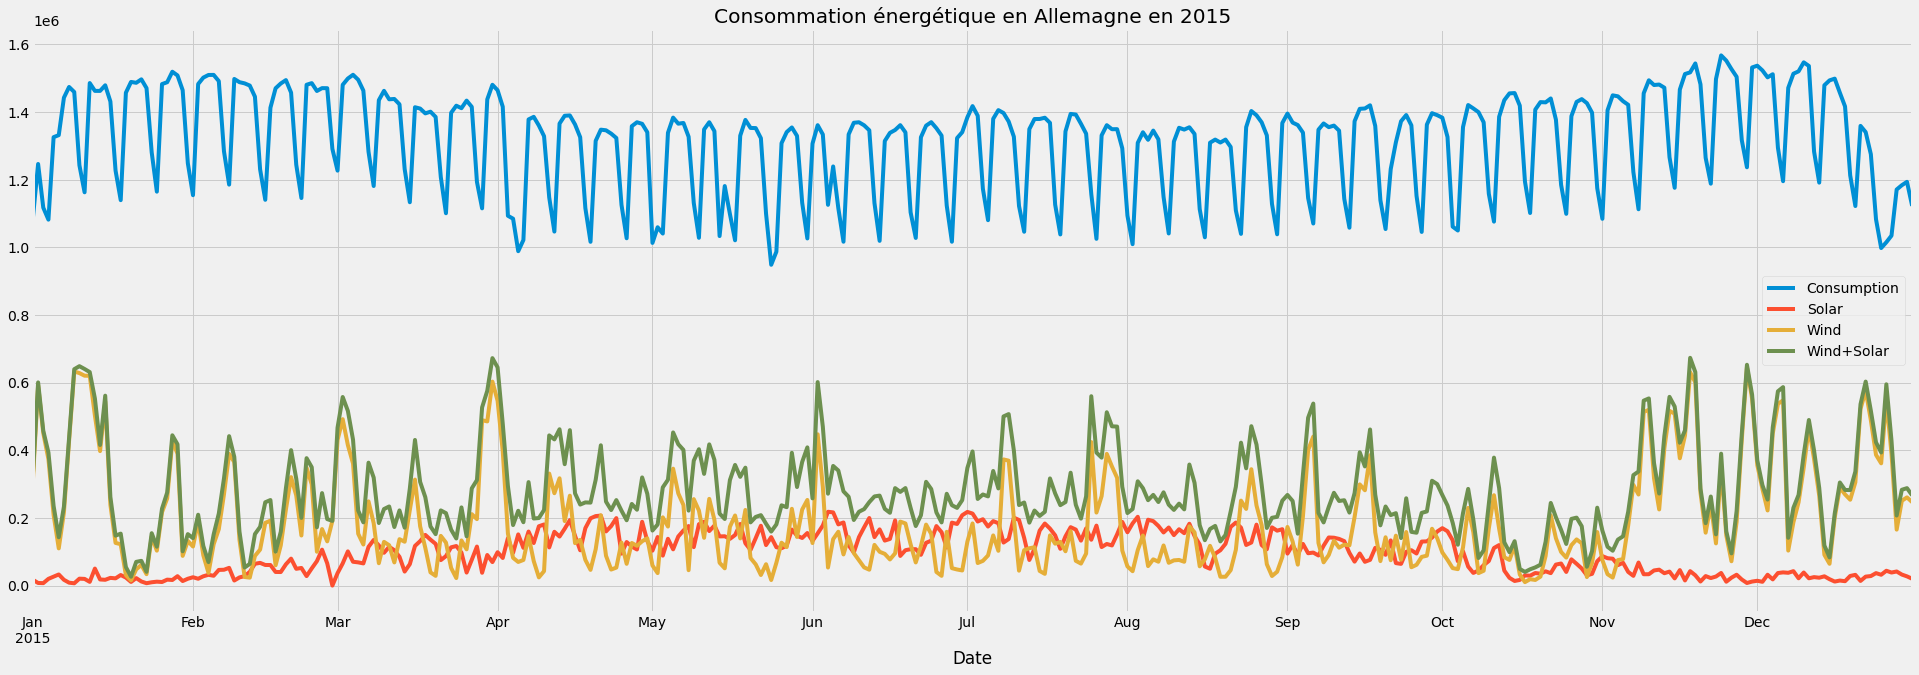

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,10))
(df[:365]['Consumption']).plot()
(df[:365]['Solar']).plot()
(df[:365]['Wind']).plot()
(df[:365]['Wind+Solar']).plot()
plt.title("Consommation énergétique en Allemagne en 2015")
plt.legend()
plt.show()

### 2. Changemant de l'échelle

Q2 - Essayons de changer l'échelle pour comprendre les modèles récurrents.

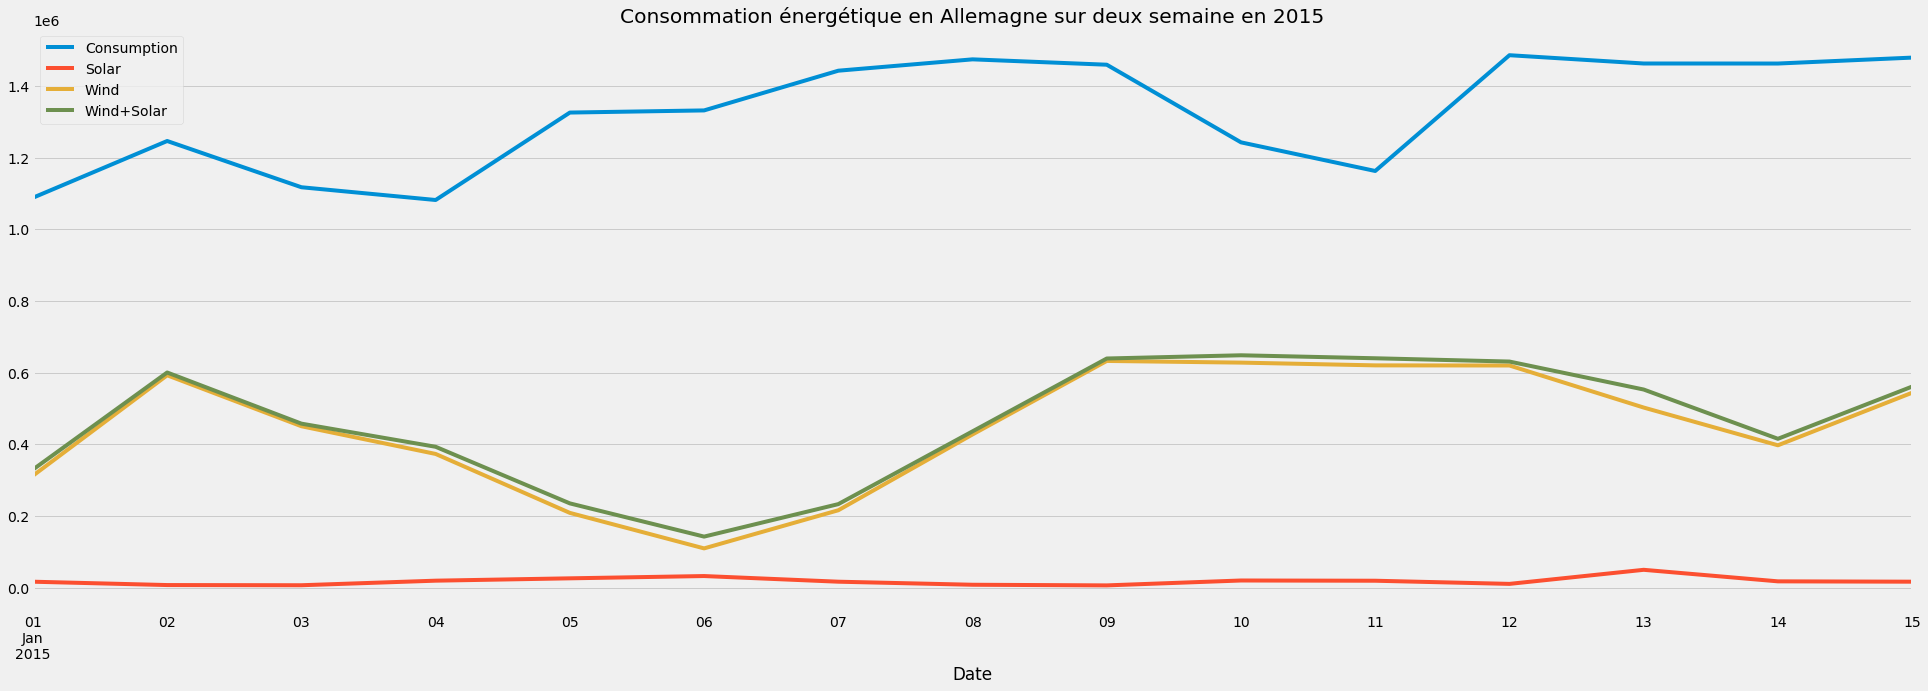

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,10))
(df[:15]['Consumption']).plot()
(df[:15]['Solar']).plot()
(df[:15]['Wind']).plot()
(df[:15]['Wind+Solar']).plot()
plt.title("Consommation énergétique en Allemagne sur deux semaine en 2015")
plt.legend()
plt.show()

### 3. Poursuite de l'exploration

Q3 - Pour explorer davantage l'ensemble de données, nous pourrions avoir besoin de regrouper les données. Créez de nouvelles colonnes pour la consommation (par année et par mois) ensuite créeation des boîtes à moustaches avec **`seaborn`**. Voir les résultats.

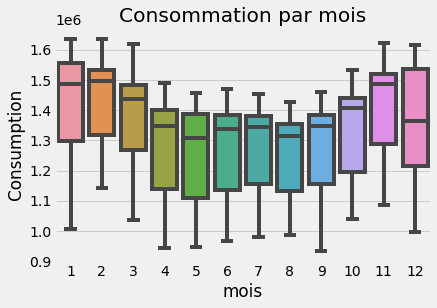

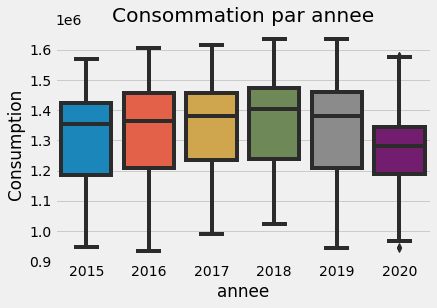

In [11]:
df["mois"]=df.index.month
df["annee"]=df.index.year
cat_feat = ['mois', 'annee']
for col in cat_feat:
    sns.boxplot(x=df[col], y=df['Consumption'])
    plt.title('Consommation par '+ col)
    plt.show()
df.drop(['annee', 'mois'], axis=1, inplace=True)

### 4. Remplissage des valeurs manquantes

Q4 - Faites-vous face à des valeurs manquantes dans la production? Si oui, quelle méthode pouvez-vous appliquer? Que se passe-t-il si vous tracez les données modifiées? Est-ce une bonne idée de conserver les données de cette façon?

In [12]:
# On check les valeurs à 0 car pas de nan
# On les replace par des nan pour pouvoir les remplir
df.loc[df.Solar==0.0, "Solar"] = np.nan
# On rempli les trous
df.bfill(inplace=True)

### 5. Corrélation de séries

Q5 - Une bonne façon d'explorer les séries chronologiques, lorsque vous avez plusieurs séries, est de tracer une série par rapport à une autre. C'est un bon moyen d'estimer la corrélation entre 2 séries. Tracez les graphiques pertinents (et calculez la corrélation) pour le vent + le solaire vs la consommation, le vent vs la consommation, le solaire vs la consommation et le vent vs le solaire.

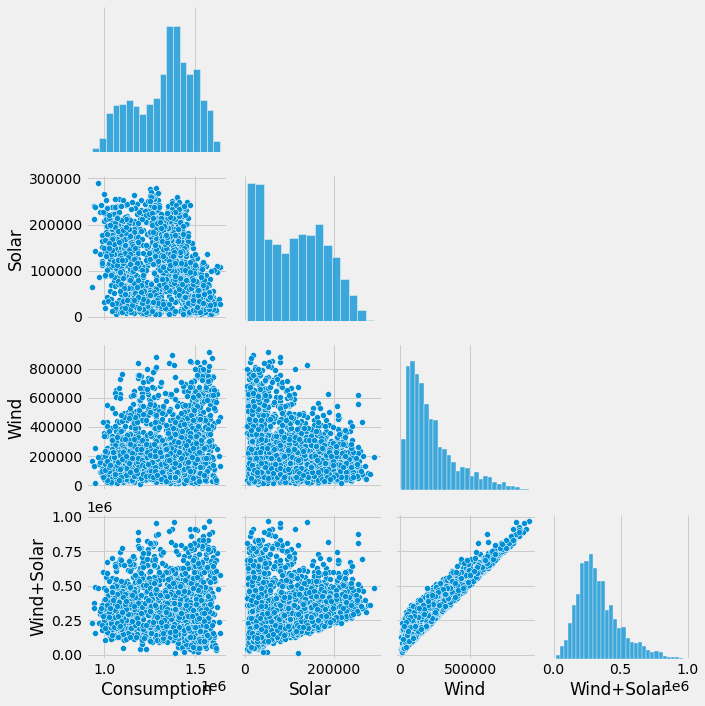

In [13]:
sns.pairplot(df, corner=True)

<Axes: >

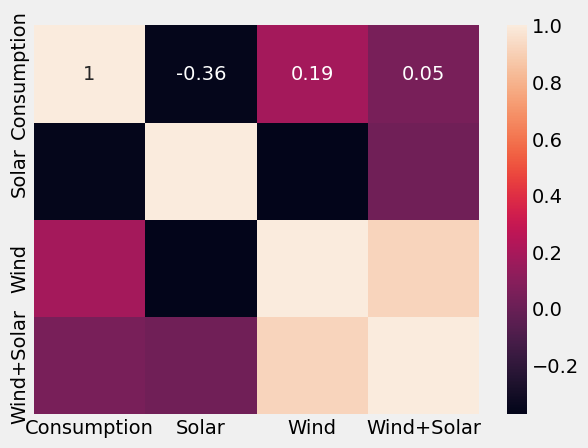

In [20]:
sns.heatmap(df.corr(), annot=True)

# PARTIE 2 : Prédiction de la consommation d'électricité

Dans cette partie, il vous est demandé d'utiliser les informations de l'exploration précédente et de construire des prévisions pour la consommation d'électricité.

### 1. Concepts clés des séries chronologiques

Pour la suite, nous nous concentrerons uniquement sur la consommation (et la prédiction de la consommation).

Q1 - Tracer l'autocorrélation et l'autocorrélation partielle de la consommation. Que remarquez-vous?

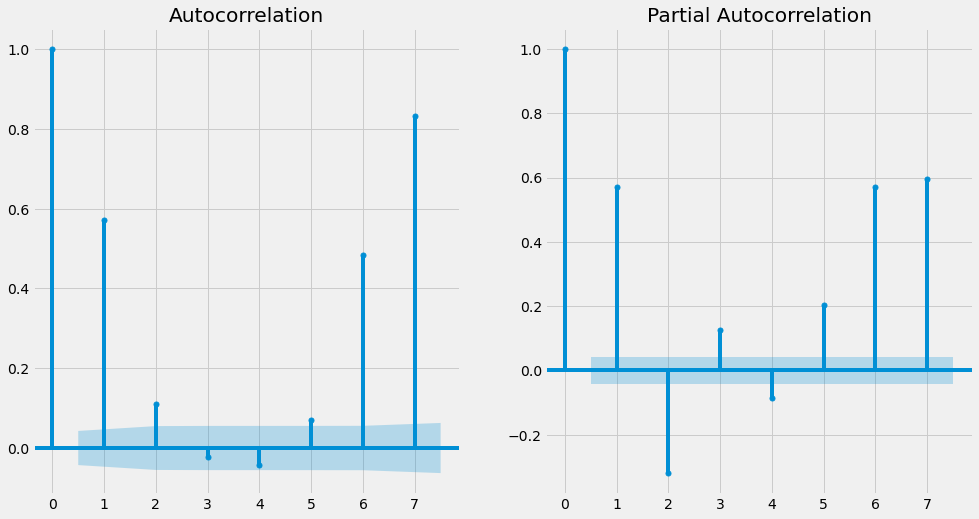

In [14]:
import statsmodels.api as sm
fig, axes = plt.subplots(1,2, figsize=(15,8))
sm.graphics.tsa.plot_acf(df["Consumption"], lags=7, ax=axes[0]);
sm.graphics.tsa.plot_pacf(df["Consumption"], lags=7, ax=axes[1]);

Q2 - La série est-elle stationnaire?

In [26]:
#from statsmodels.tsa.stattools import adfuller

#result = adfuller(df['Consumption'].ffill(0))
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
#    print('\t%s: %.3f' % (key, value))

In [15]:
from statsmodels.tsa.stattools import adfuller
df['Consumption'] = df['Consumption'].ffill()

# Test ADF
result = adfuller(df['Consumption'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.593460971848508
p-value: 0.00013280221269339039
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


La p-value est << 0.05 donc oui la série est stationnaire

Q3 - Pouvez-vous penser à une technique qui pourrait aider notre futur modèle à être plus précis?

Nous pourrions essayer de supprimer la tendance (bien qu'il n'y ait pas de tendance claire). Nous pourrions également supprimer la saisonnalité de la série chronologique.


### 2. Les tendances

Q4 - Essayez d'isoler la tendance comme vu en cours. Conclure sur le résultat.

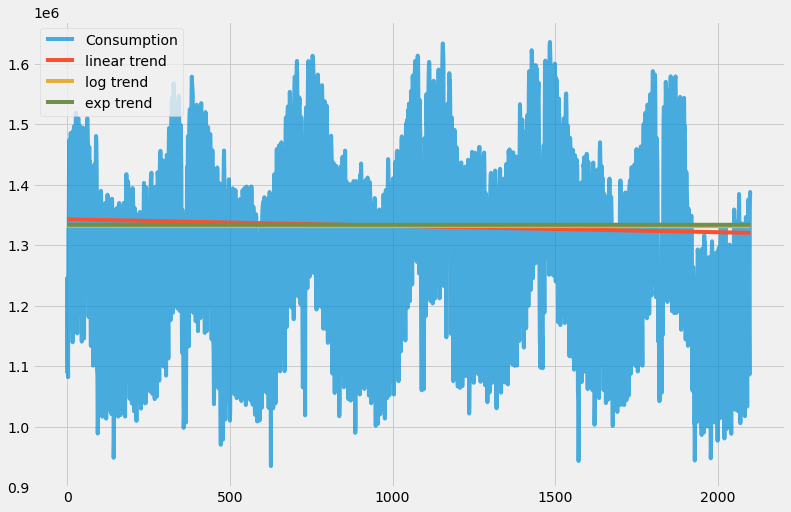

In [16]:
from sklearn.linear_model import LinearRegression

X = np.array(range(len(df['Consumption'])))
y = df['Consumption']

reg = LinearRegression().fit(X.reshape(-1,1), y)
pred_lin = reg.predict(X.reshape(-1,1))

a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)

pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

plt.figure(figsize=(12,8))
plt.plot(df['Consumption'].values,  label="Consumption", alpha=0.7)
plt.plot(pred_lin, label="linear trend")
plt.plot(pred_log, label="log trend")
plt.plot(pred_exp, label="exp trend")
plt.legend()
plt.show()

### 3. Saisonnalité

Q5 - Essayez de supprimer la saisonnalité. Conclure sur le résultat.

In [17]:
df.Consumption = df.Consumption - pred_lin

In [19]:
series = df.Consumption - df.Consumption.shift(365)

Text(0.5, 1.0, 'residus de la serie temporelle')

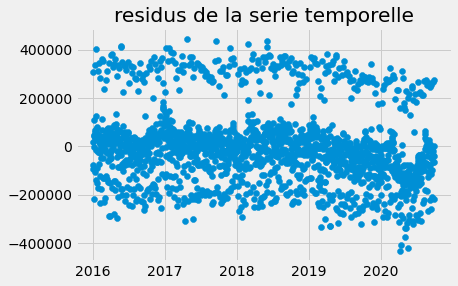

In [20]:
plt.scatter(df.index, series)
plt.title("residus de la serie temporelle")

Q6 - Que donne le test ADFuller maintenant ? Avez-vous amélioré quelque chose ?

In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.409536
p-value: 0.000286
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Notre série temporelle est toujours stationnaire, pas d'amélioration notable de la stationnarité, la p-value n'a pas beaucoup changé

### 4. Décomposition automatique

Q7 - La décomposition automatique de **`statsmodels`** identifie-t-elle autre chose ?

In [22]:
# On réinclu la tendance avant la décomposition automatique :
df.Consumption = df.Consumption + pred_lin

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.Consumption, period=365, 
                                   extrapolate_trend='freq')

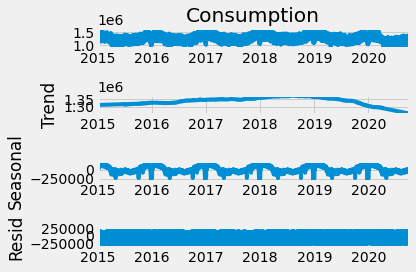

In [24]:
decomposition.plot();

### 5. Modélisez la série stationnaire

Q8 - Prendre des années de données d'entraînement n'est pas toujours la meilleure idée. Sur la base de la décomposition ci-dessus, quel délai semble le plus pertinent?

In [25]:
series = series[-800:]

**Processus de moyenne mobile (MA)**

Q9 - Appliquer un processus de moyenne mobile sur 20% des données de test. Commentez vos résultats.

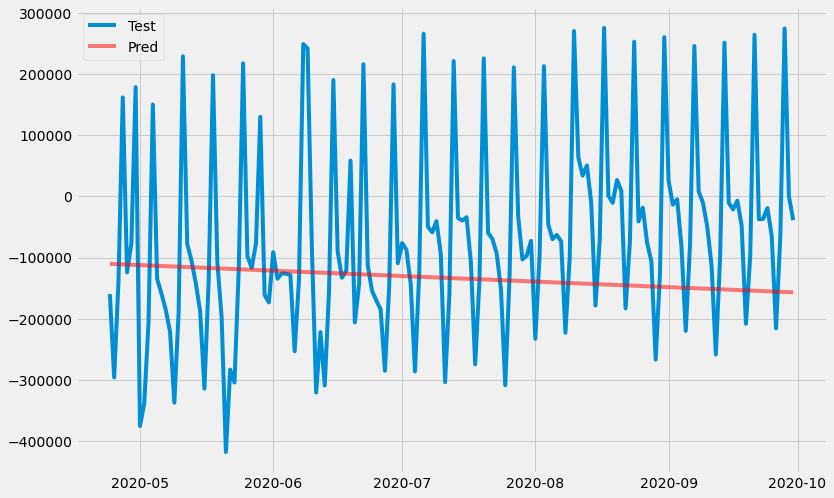

In [26]:
# We ignore the warnings.
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

size = int(len(series) * 0.80)
train, test = series[0:size], series[size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(pd.Series(predictions, index=test.index), color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

**Processus autorégressifs (AR)**

Q10 - Appliquer un processus autorégressif sur 20% des données de test. Commentez vos résultats.

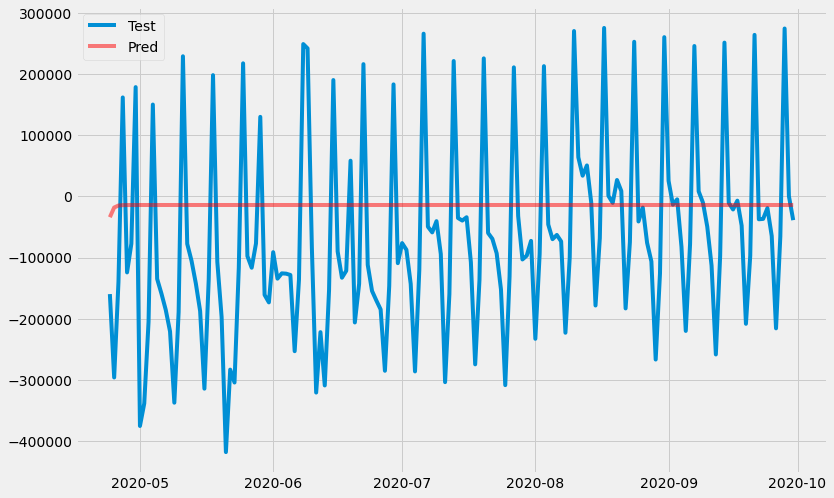

In [27]:
# We ignore the warnings.
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

size = int(len(series) * 0.80)
train, test = series[0:size], series[size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(pd.Series(predictions, index=test.index), color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

**Processus de moyenne mobile auto-régressive (ARMA)**

Q11 - Appliquer un processus de moyenne mobile auto-régressive sur 20% des données de test. Commentez vos résultats.

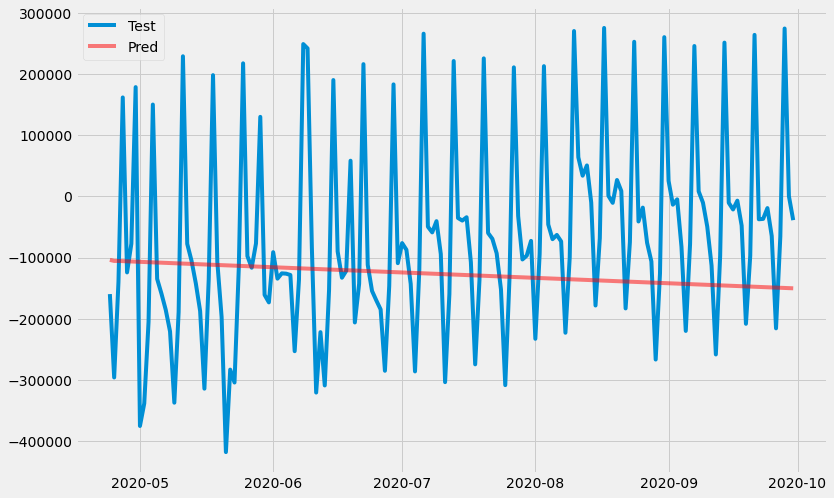

In [28]:
# We ignore the warnings.
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

size = int(len(series) * 0.80)
train, test = series[0:size], series[size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(pd.Series(predictions, index=test.index), color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

**Processus ARIMA (Auto Regressive Integrated Moving Average)**

Q12 - Appliquer un processus de moyenne mobile intégrée auto-régressive sur 5% des données de test. Commentez vos résultats.

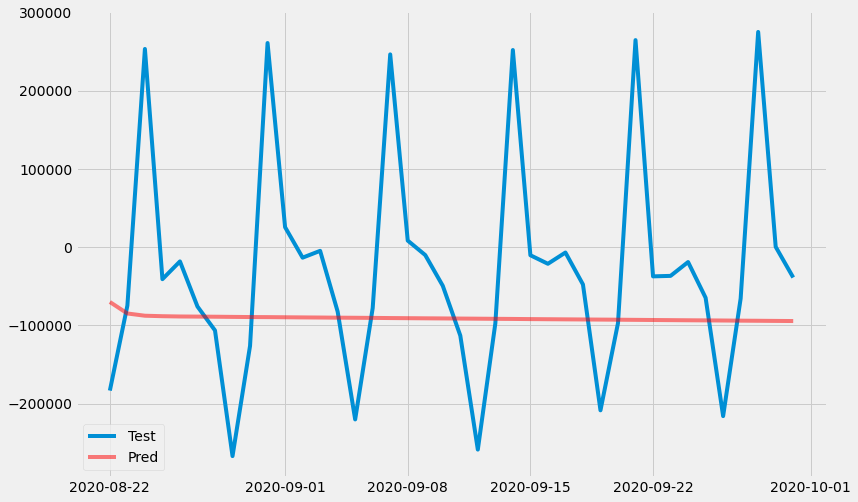

In [29]:
# We ignore the warnings.
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

size = int(len(series) * 0.95)
train, test = series[0:size], series[size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(pd.Series(predictions, index=test.index), color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

**Processus de moyenne mobile intégrée autorégressive saisonnière (SARIMA)**

Q13 - Il existe une tendance saisonnière au fil du temps que nous ne pouvons pas supprimer. SARIMA pourrait vous aider! Ajuster et prédire avec un modèle SARIMA sur 80% des données.

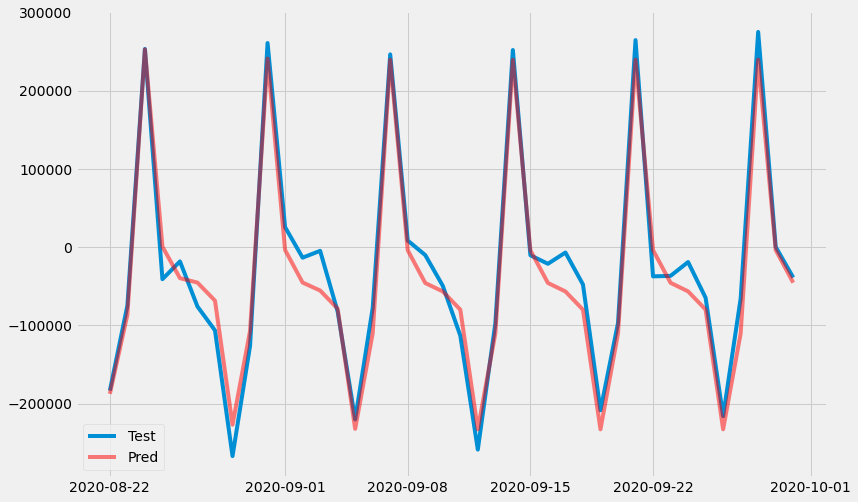

In [30]:
# We ignore the warnings.
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

size = int(len(series) * 0.95)
train, test = series[0:size], series[size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1),
                   seasonal_order=(1,1,1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(pd.Series(predictions, index=test.index), color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

## BONUS :

Q14 - Réaliser une prédiction avec la librairie **`prophet`**.

In [51]:
from prophet import Prophet
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Selection des colonnes et mise au format pour la librairie fbprophet
ts = df["Consumption"].reset_index().rename(columns={"Date":"ds", "Consumption":"y"})
ts.head()

,ds,y
0,2015-01-01 00:00:00+00:00,1088317.0
1,2015-01-02 00:00:00+00:00,1246588.0
2,2015-01-03 00:00:00+00:00,1117554.0
3,2015-01-04 00:00:00+00:00,1081980.0
4,2015-01-05 00:00:00+00:00,1325920.0


In [52]:
# Suppression de la timezone de la colonne date :
ts.ds = ts.ds.dt.tz_localize(None)

model = Prophet(interval_width=.95)
model.fit(ts)

# Generation de jours pour prédire dans le futur
futur_ts = model.make_future_dataframe(periods=60, freq="D")

# Prediction: 
forecast = model.predict(futur_ts)

12:05:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing


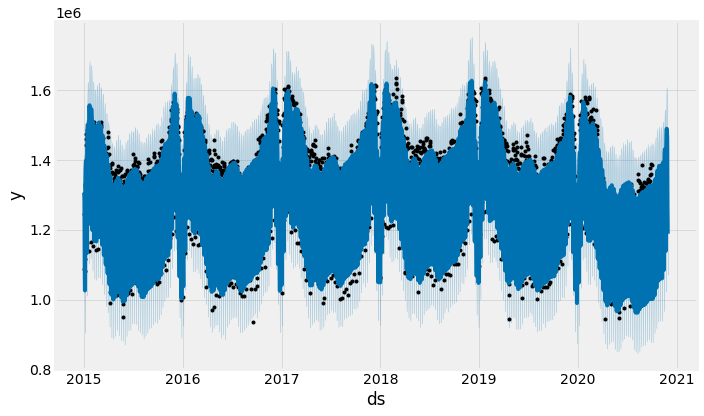

In [53]:
# Affichage de la prédiction
model.plot(forecast);

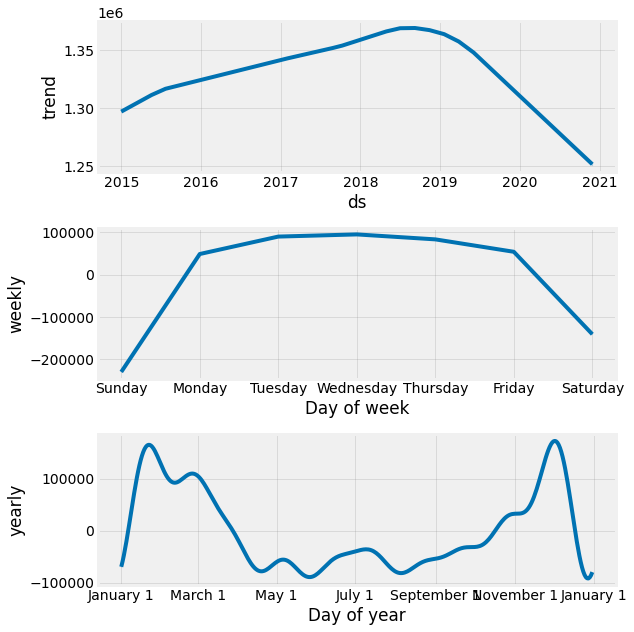

In [54]:
# Composantes de la prédiction
model.plot_components(forecast);
